In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import figure
from ipywidgets import interact
import pandas as pd
from scipy.optimize import fsolve
import oapackage
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, VBox, ButtonStyle, GridBox, SliderStyle
from termcolor import colored
import sys
import os
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
from file_reader import FileReader


fr = FileReader()


In [2]:
def excel_reader(filename):
    file = pd.ExcelFile(filename)
    dd = {}
    for sheet_name in file.sheet_names:
        dd[sheet_name] = file.parse(sheet_name)
    return dd


def ellipse_tangent(z, *data):
    coord, dim = data
    h, k, p, q = coord
    a, b, A, B = dim
    x1, y1, x2, y2 = z

    f1 = A**2*b**2*(x1-h)*(y2-q)/(a**2*B**2*(x2-p)*(y1-k)) - 1
    f2 = (x1-h)**2/a**2 + (y1-k)**2/b**2 - 1
    f3 = (x2-p)**2/A**2 + (y2-q)**2/B**2 - 1
    f4 = -b**2*(x1-x2)*(x1-h)/(a**2*(y1-y2)*(y1-k)) - 1

    return f1, f2, f3, f4

def pareto_front(x, y, reverse='bottom'):
    if reverse == 'top':
        def reverse_list(l):
            return l
    else:
        def reverse_list(l):
            return [-x for x in l]

    datapoints = np.array([reverse_list(x), reverse_list(y)])
#     print(datapoints)

    pareto = oapackage.ParetoDoubleLong()

    for ii in range(0, datapoints.shape[1]):
        w = oapackage.doubleVector((datapoints[0, ii], datapoints[1, ii]))
        pareto.addvalue(w, ii)

    pareto.show(verbose=1)

    lst = pareto.allindices()  # the indices of the Pareto optimal designs

    optimal_datapoints = datapoints[:, lst]
    return reverse_list(optimal_datapoints[0, :]), reverse_list(optimal_datapoints[1, :])

def select_points_from_pareto(x, y):
    # select from pareto
    p_select_FM, p_select_HOM = [], []
    for fm, hom in zip(x, y):

        if fm == min(x):
            p_select_FM.append(fm)
            p_select_HOM.append(hom)

        if hom == min(y):
            p_select_FM.append(fm)
            p_select_HOM.append(hom)
            
    return p_select_FM, p_select_HOM


In [3]:
def get_plot_data(filename):
    d_FM_HOM = excel_reader(filename)
    d_FM_HOM = d_FM_HOM['Sheet1']
    
    ob_FM_HOM_dict = {}
    for key, val in d_FM_HOM.iterrows():
        ob_FM_HOM_dict[int(val['key'])] = list(val)[2:]
    
    ob_k_loss_long, ob_k_loss_trans, ob_Epk_Eacc, ob_Bpk_Eacc = [], [], [], []
    for key, val in ob_FM_HOM_dict.items():
        ob_k_loss_long.append(val[-3]/0.03)
        ob_k_loss_trans.append(val[-2]/0.3)
        ob_Epk_Eacc.append(val[-7]/2.2)
        ob_Bpk_Eacc.append(val[-6]/5)
                  
    return ob_k_loss_long, ob_k_loss_trans, ob_Epk_Eacc, ob_Bpk_Eacc, ob_FM_HOM_dict

def get_plot_data_w_Z(filename):
    d_FM_HOM = excel_reader(filename)
    d_FM_HOM = d_FM_HOM['Sheet1']
    
    ob_FM_HOM_dict = {}
    for key, val in d_FM_HOM.iterrows():
#         ob_FM_HOM_dict[int(val['key'])] = list(val)[2:]
        ob_FM_HOM_dict[key] = list(val)[1:]
    
    ob_Z_loss_long, ob_Z_loss_trans, ob_Epk_Eacc, ob_Bpk_Eacc = [], [], [], []
    for key, val in ob_FM_HOM_dict.items():
        ob_Z_loss_long.append(val[-2]/0.3)
        ob_Z_loss_trans.append(val[-1]/3)
        ob_Epk_Eacc.append(val[-7-2]/2.2)
        ob_Bpk_Eacc.append(val[-6-2]/5)
                  
    return ob_Z_loss_long, ob_Z_loss_trans, ob_Epk_Eacc, ob_Bpk_Eacc, ob_FM_HOM_dict

def plot_settings():
    # plot settings
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams["figure.figsize"] = (8, 6)
    mpl.rcParams['lines.markersize'] = 10
    # axes
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['axes.titlesize'] = 14

    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12

def get_plot_data_pandas(filename):
    df = pd.read_excel(filename, 'Sheet1')
    
    df = df[df['L'] == 187]
                  
    return df

def weighted_norm(l, norm=2):
    weighted_sum = sum([x**norm for x in l])
    return weighted_sum**(1/norm)
    
plot_settings()
# get_plot_data_pandas(fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\2023_17_07_combined_results\all_results_abci_slans (including deleted results).xlsx')

## Weighted exponential norm method

In [4]:
# # get plot data

# get plot data all shapes
# filename_5d6d = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\all_results_abci_slans.xlsx'
filename_5d6d = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\2023_17_07_combined_results\all_results_abci_slans (including deleted results).xlsx'
# filename_5d6d = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\2023_17_07_combined_results\short_testing.xlsx'
df = get_plot_data_pandas(filename_5d6d)

# apply long impedance filters
df = df[(df['Z_long[max(0.44<f<0.77)]'] <= 0.03) | (df['Z_long[max(0.77<f<1.1)]'] < 0.2) | 
        (df['Z_long[max(1.1<f<2.0)]'] < 0.21)]

# apply trans impedance filters
df = df[(df['Z_trans[max(0.54<f<0.59)]'] <= 1.3) | (df['Z_trans[max(0.59<f<0.75)]'] == 0) | 
        (df['Z_trans[max(0.75<f<1.05)]'] <= 1.5) | (df['Z_trans[max(1.05<f<2.0)]'] <= 0.41)]

# apply fm filters
df = df[(df['Epk/Eacc'] <= 2.4) & (df['Bpk/Eacc'] <= 6.5)]
# df = df[(df['Ri'] == 150)]

ob_k_loss_long = df['k_loss_long']/0.3
ob_k_loss_trans = df['k_loss_trans']/3
ob_Epk_Eacc = df['Epk/Eacc']/2.2
ob_Bpk_Eacc = df['Bpk/Eacc']/5

# group_5d6d = [ob_k_loss_long, ob_k_loss_trans, ob_Epk_Eacc, ob_Bpk_Eacc, corresponding_shape_space]
group_5d6d = [ob_k_loss_long, ob_k_loss_trans, ob_Epk_Eacc, ob_Bpk_Eacc]
data_group_list = [group_5d6d]

# # get plot data
# filename = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\modules\data_module\COMPLETE_8388_5D_space.xlsx'
# filename = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\modules\data_module\COMPLETE_9064_6D_space.xlsx'
# filename = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\modules\data_module\COMPLETE_THIRD_BATCH_5D_9276.xlsx'
# filename = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\modules\data_module\COMPLETE_LOCAL_SWEEP_2D.xlsx'
# filename = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\modules\data_module\COMPLETE_LOCAL_SWEEP_2_2D.xlsx'
# filename = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\modules\data_module\COMPLETE_FOURTH_BATCH_RI155.xlsx'



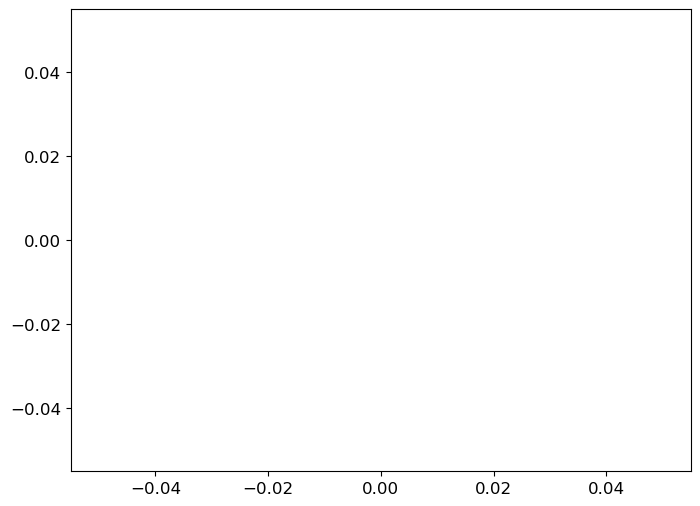

interactive(children=(FloatSlider(value=1.0, description='e', layout=Layout(flex='1 1 auto', width='auto'), ma…

In [15]:
plt.close()
group_color = ['b', 'c', 'salmon']
pareto_color = ['salmon', '.y', '.m']
label = ['Cavity geometry', 'Outputs (Ri=155 mm)', 'Outputs (Ri=150 mm)']
p_label = ['Pareto front', 'Pareto (Outputs (Ri=155 mm))', 'Pareto (Outputs (Ri=150 mm))']
bw_list = [0, 0, 0.05]

# create sliders
e = widgets.FloatSlider(min=0, max=1, value=1, step=0.05, layout=Layout(flex='1 1 auto', width='auto'),
                 style=SliderStyle(button_color='lightblue'))
b = widgets.FloatSlider(min=0, max=1, value=1, step=0.05, layout=Layout(flex='1 1 auto', width='auto'),
                 style=SliderStyle(button_color='lightblue'))
kl = widgets.FloatSlider(min=0, max=1, value=1, step=0.05, layout=Layout(flex='1 1 auto', width='auto'),
                 style=SliderStyle(button_color='lightblue'))
kt = widgets.FloatSlider(min=0, max=1, value=1, step=0.05, layout=Layout(flex='1 1 auto', width='auto'),
                 style=SliderStyle(button_color='lightblue'))
bw = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05, layout=Layout(flex='1 1 auto', width='auto'),
                 style=SliderStyle(button_color='lightblue'))

items = [Box([e]), Box([b]), Box([kl]), Box([kt])]

box_layout = Layout(
            grid_template_rows='auto',
            grid_template_columns='25% 25% 25% 25%',
                    width='70%')

box = GridBox(children=items, layout=box_layout)

fig, ax = plt.subplots(figsize=[8, 6])
nn = 2   
sca = ax.scatter([], [], facecolors='none', edgecolors='gray', s=30)                       
line, = ax.plot([], [], 'none', marker='o', ls='None', markersize=6, mec='k', zorder=2) #, markerfacecolor='None'
sca2 = ax.scatter([], [], facecolors='salmon', edgecolors='k', label="Selected shape", s=60, zorder=4)

@interact
def obj(e=e, b=b, kl=kl, kt=kt, bw=bw):
    group_count = 1
#     axins = ax.inset_axes([0.65, 0.5, 0.34, 0.47], facecolor='#fafafa')
    for col_indx, group_data in enumerate(data_group_list):
        
        # multiply objectives by control weights
        ob_Epk_Eaccf = group_data[2]*e
        ob_Bpk_Eaccf = group_data[3]*b
        ob_k_loss_longf = group_data[0]*kl
        ob_k_loss_transf = group_data[1]*kt        

        # calculate objective functions
        if nn != 'inf':
            ob_FM = weighted_norm([ob_Epk_Eaccf, ob_Bpk_Eaccf], nn)
            ob_HOM = weighted_norm([ob_k_loss_longf,  ob_k_loss_transf], nn)
        else:  
            ob_FM = max(ob_Epk_Eaccf, ob_Bpk_Eaccf)
            ob_HOM = max(ob_k_loss_longf, ob_k_loss_transf)
        

        # pareto
        ob_HOM_opt, ob_FM_opt = pareto_front(ob_HOM.tolist(), ob_FM.tolist())
        
        # selected shapes
        p_select_FM, p_select_HOM = select_points_from_pareto(ob_FM_opt, ob_HOM_opt)

#         # plot span
# #         bw = bw_list[col_indx]
#         bw = bw
#         bw_HOM = bw*(max(ob_HOM_opt)-min(ob_HOM_opt)) # 10% of the interval
#         bw_FM = bw*(max(ob_FM_opt)-min(ob_FM_opt)) # 10% of the interval

# #         plt.axvspan(min(ob_HOM_opt)-0.05, min(ob_HOM_opt)+bw_HOM, facecolor='#fc4f3044')
# #         plt.axhspan(min(ob_FM_opt)-0.05, min(ob_FM_opt)+bw_FM, facecolor='#e5ae3844')

#         # select points in span
#         bw_selection_FM, bw_selection_HOM = [], []
#         for fm, hom in zip(ob_FM_opt, ob_HOM_opt):
# #             if min(ob_FM_opt) < fm < min(ob_FM_opt)+bw_FM:
# #                 bw_selection_FM.append(fm)
# #                 bw_selection_HOM.append(hom)

#             if min(ob_HOM_opt) < hom < min(ob_HOM_opt)+bw_HOM:
#                 bw_selection_FM.append(fm)
#                 bw_selection_HOM.append(hom)


#         # print shapes corresponding to points
#         print('shape keys')
#         for fm, hom in zip(p_select_FM, p_select_HOM): # from pareto optimal
#             if ob_FM.index(fm) == ob_HOM.index(hom):
#     #             print(ob_FM.index(fm))
#                 key = ob_FM.index(fm)
        
#                 SHAPE_ = group_data[4][ob_FM.index(fm)][0:8]
#                 FM_ = [round(x, 2) for x in group_data[4][ob_FM.index(fm)][-9:-7]]
#                 HOM_ = [round(x) for x in group_data[4][ob_FM.index(fm)][-2:]]
#                 print(colored((f'Point: {round(hom, 2), round(fm,2)}, key: {key}, Shape: {SHAPE_}, FM: {FM_}, HOM: {HOM_}'), 'green'))

#         print()
#         print("Bandwidth Selected")
#         for fm, hom in zip(bw_selection_FM, bw_selection_HOM): # from pareto plus bandwidth
#             if ob_FM.index(fm) == ob_HOM.index(hom):
#     #             print(ob_FM.index(fm))
#                 key = ob_FM.index(fm)
                
#                 SHAPE_ = group_data[4][ob_FM.index(fm)][0:7]
#                 FM_ = [round(x, 2) for x in group_data[4][ob_FM.index(fm)][-9:-7]]
#                 HOM_ = [round(x) for x in group_data[4][ob_FM.index(fm)][-2:]]
# #                 print(colored((f'Point: {round(hom, 2), round(fm,2)}, key: {key}, Shape: {SHAPE_}, FM: {FM_}, HOM: {HOM_}'), 'yellow'))
    
    #     plt.style.use(['science', 'no-latex'])

# #         # plots
#         if group_count: #plot for only bigger set
#             ax.plot(p_select_HOM, p_select_FM, '.g', markersize=18, label='Selected', zorder=3)
#             ax.plot(choose[0], choose[1], '.g', markersize=18, label='Selected Shape(s)', zorder=4)
#             axins.plot(choose[0], choose[1], '.g', markersize=18, zorder=4)

#             ax.plot(bw_selection_HOM, bw_selection_FM, '.y', markersize=18, label='BW Selected', zorder=3)
        
#         ax.scatter(ob_HOM, ob_FM, facecolors='none', edgecolors='gray', label=label[col_indx], s=30)
#         print(ob_HOM_opt)
        sca.set_offsets(np.column_stack((ob_HOM, ob_FM)))
        sca.set_label(label[col_indx])
        # plot pareto
#         ax.plot(ob_HOM_opt, ob_FM_opt, 'none', marker='o', ls='None', markersize=6, mec='k', label=p_label[col_indx], zorder=2) #, markerfacecolor='None'
        line.set_data(ob_HOM_opt, ob_FM_opt)
        line.set_label(p_label[col_indx])
        # print pareto shapes
        pareto_shapes_dict = {}
#         for hom, fm in zip(ob_HOM_opt, ob_FM_opt):
#             df_ = df[(weighted_norm([df['Epk/Eacc']*e/2.2, df['Bpk/Eacc']*b/5], nn) == fm) & 
#                      (weighted_norm([df['k_loss_long']*kl/0.3, df['k_loss_trans']*kt/3], nn)==hom)]
#             print(len(df_))
#             key = df_['key'].iloc[0]
# #             print(key, fm, hom)
            
#             pareto_shapes_dict[key] = {'IC': df_[['A', 'B', 'a', 'b', 'Ri', 'L', 'Req', 'alpha']].values.tolist()[0], 
#                                        'OC': df_[['A', 'B', 'a', 'b', 'Ri', 'L', 'Req', 'alpha']].values.tolist()[0],
#                                        'FREQ': 400.79,
#                                        'BP': 'both'}
        # save pareto shapes dict
#         with open(fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\2023_17_07_combined_results\pareto_shapes.json', "w") as outfile:
#             json.dump(pareto_shapes_dict, outfile, indent=4)
            
        # pick any shape
        shape_pick = df[df['key'] == 'Cavity3794_Ri_150_L_187']
        sp_fm = weighted_norm([shape_pick['Epk/Eacc']*e/2.2, shape_pick['Bpk/Eacc']*b/5], nn)
        sp_hom = weighted_norm([shape_pick['k_loss_long']*kl/0.3, shape_pick['k_loss_trans']*kt/3], nn)
                                
#         ax.scatter(sp_hom, sp_fm, facecolors='salmon', edgecolors='k', label="Selected shape", s=60, zorder=4)
        print("this is", sp_hom, sp_fm)
        sca2.set_offsets(np.column_stack((sp_hom, sp_fm)))
        group_count += 1
        print('='*50)
    ax.set_ylabel('$\phi_{\mathrm{FM}}$')
    ax.set_xlabel('$\phi_{\mathrm{HOM}}$')
    
#     # sub region of the original image
#     x1, x2, y1, y2 = 0.8, 1.6, 1.4, 1.6
#     axins.set_xlim(x1, x2)
#     axins.set_ylim(y1, y2)
    
    ax.legend(loc='upper right')
    plt.savefig(fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\modules\data_module\pareto.png', transparent=True, bbox_inches='tight', pad_inches=0.2)
    ax.relim()  # <- calculate new lims
    ax.autoscale_view()  # <- update lims
    fig.canvas.draw_idle()


# Impedance plots

# Plot ABCI compare

In [ ]:
import os

%matplotlib notebook
import mpld3
mpld3.enable_notebook()

print(os.getcwd())
os.chdir(fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI')
print(os.getcwd())
from modules.data_module.abci_data import ABCIData

def calc_cutoff(Ri, mode):
    # calculate frequency from Ri
    p_TM01, p_TE11 = 2.405, 1.841
    c = 299792458 # m/s
    
    if mode == 'TM01': 
        freq = 400.79 * 1e-3
    elif mode == 'TE11':
        freq = (c*p_TE11)/(2*np.pi * Ri * 1e9) * 1e3
       
    return freq

def calc_limits(mode, f=0):
    E0 = [45.6, 80, 120, 182.5] # [GeV] Energy
    nu_s = [0.025, 0.0506, 0.036, 0.087] # Synchrotron oscillation tune 
    I0 = [1390, 147, 29, 5.4*2] # [mA] Beam current 
    alpha_c = [1.48, 1.48, 0.73, 0.73] # [10−5] Momentum compaction factor 
    tau_z = [424.6, 78.7, 23.4, 6.8] # [ms] Longitudinal damping time
    tau_xy = [849.2, 157.4, 46.8, 13.6] # [ms] Transverse damping time 
    frev = [3.07, 3.07, 3.07, 3.07] # [kHz] Revolution frequency 
    beta_xy = 50
    
#     Ncav = [52, 52, 136, 584] # Number of cavities per beam
    Ncav = [52, 100, 268, 584] # 1_2_2_25
    
    Z_list = []
    if mode == 'monopole':
        # trim f
        f = f[0:len(f)-100]
        for i, n in enumerate(Ncav):
            Z = [(2*E0[i]*nu_s[i])*1e8/(n*I0[i]*alpha_c[i]*tau_z[i]*a) if a>1e-8 else 1e5 for a in f]
            Z_list.append(Z)
            
        return f, Z_list
    elif mode == 'dipole':
        for i, n in enumerate(Ncav):
            Z = (2*E0[i])*1e9/(n*I0[i]*beta_xy*tau_xy[i]*frev[i])
            Z_list.append(Z)
        
        return Z_list

        
def plot_impedance(cavity_list, typ):
    fig, ax = plt.subplots(figsize=[9.8, 6])
    
    if typ == 'trans':
        # inset axes....
        axins = ax.inset_axes([0.65, 0.5, 0.34, 0.47], facecolor='#fafafa')
    
    plot_count = 1
    for l in cavity_list:
        if l[1] == 0:
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\Second 9063\ABCI'
            
            if type(l[0]) != type('str'): 
                filename = r'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Cavity Population\shape_space_Lvar_weed.json'
                dd = fr.json_reader(filename)[l[0]]['MC']
                print(dd)
                Ri = dd[4]
        elif l[1] == 1:
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\First 8388\ABCI_Req_Results'
            
            if type(l[0]) != type('str'): 
                filename = r'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Cavity Population\shape_space_Reqvar_weed.json'
                dd = fr.json_reader(filename)[l[0]]['MC']
                print(dd)
                Ri = dd[4]
        elif l[1] == 2:
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\Third 9276\ABCI'
            
            if type(l[0]) != type('str'): 
                filename = r'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Cavity Population\third_batch_weed.json'
                dd = fr.json_reader(filename)[l[0]]['MC']
                print(dd)
                Ri = dd[4]
                
        elif l[1] == 3:
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\Local Sweep\ABCI'
            
            if type(l[0]) != type('str'): 
                filename = r'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Cavity Population\local_sweep_weed.json'
                dd = fr.json_reader(filename)[l[0]]['MC']
                print(dd)
                Ri = dd[4]
                
        elif l[1] == 4:
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\Local Sweep 2\ABCI'
            
            if type(l[0]) != type('str'): 
                filename = r'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Cavity Population\local_sweep_2__weed.json'
                dd = fr.json_reader(filename)[l[0]]['MC']
                print(dd)
                Ri = dd[4]
                
        elif l[1] == 5:
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\Fourth 6405\ABCI'
            
            if type(l[0]) != type('str'): 
                filename = r'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Cavity Population\fourth_batch_Ri155_weed.json'
                dd = fr.json_reader(filename)[l[0]]['MC']
                print(dd)
                Ri = dd[4]
            
                
        elif l[1] == 'Other':
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\ABCI'
            
        
        if typ == 'long':
            abci_data_long = ABCIData(abci_data_dir, l[0], 0)
            xr, yr, _ = abci_data_long.get_data('Real Part of Longitudinal Impedance')
            xi, yi, _ = abci_data_long.get_data('Imaginary Part of Longitudinal Impedance')
            y_mag = (yr**2 + yi**2)**0.5
            
            # plot
            ax.plot(xr, y_mag, label='$C_{'+f'{str(l[0])}'+'}$')
            
#             if plot_count == 1:
# #                 plot cutoffs
#                 if type(l[0]) != type('str'):
#                     freq = calc_cutoff(Ri, 'TM01')
#                     print(freq)
#                     plt.axvline(freq, ls='--', c='k')
#                     plt.text(freq-0.05, 0.02, 'FM 400 MHz', rotation=90)

#                     freq = calc_cutoff(Ri, 'TE11')
#                     plt.axvline(freq, ls='--', c='k')
#                     plt.text(freq-0.05, 0.02, '$f_{cutoff}$'+' at '+'$R_{bp} =$'+f'{Ri} mm', rotation=90)

#                     # plot baselines
#                     f, Z_list_monopole = calc_limits('monopole', f=xr)
#                     text = ['Z', 'W', 'H', 'tt']
#                     for i, z in enumerate(Z_list_monopole):
#                         plt.plot(f, z, ls='--', c='gray')
#                         plt.text(0.05, z[200], f'{text[i]}')
#                     plot_count+=1
            
            # plot settings
            plt.xlabel('$f \mathrm{ [GHz]}$')
            plt.ylabel('$Z_{\parallel, \mathrm{HOM}} \mathrm{[k\Omega]}$')
            plt.yscale('log')
            plt.ylim(1e-3, None)
            plt.xlim(0, 2)
            
            
        else:
            abci_data_trans = ABCIData(abci_data_dir, l[0], 1)
            xr, yr, _ = abci_data_trans.get_data('Real Part of Azimuthal Impedance')
            xi, yi, _ = abci_data_trans.get_data('Imaginary Part of Azimuthal Impedance')
            y_mag = (yr**2 + yi**2)**0.5
            
            # plot
            ax.plot(xr, y_mag, label='$C_{'+f'{str(l[0])}'+'}$')
            axins.plot(xr, y_mag)
            
            
#             if plot_count == 1:
#                 # plot cutoffs
#                 if type(l[0]) != type('str'):
#                     freq = calc_cutoff(Ri, 'TM01')
#                     print(freq)
#                     plt.axvline(freq, ls='--', c='k')
#                     plt.text(freq-0.05, 0.02, 'FM 400 MHz', rotation=90)

#                     freq = calc_cutoff(Ri, 'TE11')
#                     plt.axvline(freq, ls='--', c='k')
#                     plt.text(freq+0.03, 0.02, '$f_{cutoff}$'+' at '+'$R_{bp} =$'+f'{Ri} mm', rotation=90)

#                     # plot baselines
#                     Z_list_dipole = calc_limits('dipole')
#                     text = ['Z', 'W', 'H', 'tt']
#                     for i, z in enumerate(Z_list_dipole):
#                         plt.axhline(z, ls='--', c='gray')
#                         plt.text(0.05, z+1.8, f'{text[i]}')
                    
#                     plot_count+=1
            
            
            # plot settings
            plt.xlabel('$f \mathrm{[GHz]}$')
            plt.ylabel('$Z_{\perp, \mathrm{HOM}} \mathrm{[k\Omega/m]}$')

            plt.yscale('log')
            plt.ylim(1e-2, 1e2)
            plt.xlim(0.25, 2.24)
#             plt.ylim(1e-1, None) # zoom
#             plt.xlim(0.42, 0.6) # zoom
       
            # sub region of the original image
            x1, x2, y1, y2 = 0.45, 0.6, 6e-2, 1e2
            axins.set_xlim(x1, x2)
            axins.set_ylim(y1, y2)
        #     axins.set_xticklabels('')
        #     axins.set_yticklabels('')
            axins.set_yscale('log')

#     ax.indicate_inset_zoom(axins, edgecolor="black")

    # plot settings

    mpl.rcParams['xtick.labelsize'] = 15
    mpl.rcParams['ytick.labelsize'] = 15

    mpl.rcParams['axes.labelsize'] = 15
    mpl.rcParams['axes.titlesize'] = 15
    mpl.rcParams['legend.fontsize'] = 'large'
    
    plt.rcParams['figure.figsize'] = [9.8, 6]
    plt.rcParams['figure.dpi'] = 100 
    plt.legend(loc='lower left')
    
# best Hom Z
# plot_impedance([[7853, 0], [4574, 0], [6278, 0], [7288, 0], [7240, 0], [2146,0], [625, 0]], 'long')
# plot_impedance([[7853, 0], [4574, 0], [6278, 0], [7288, 0], [7418, 0], [2146,0], [637, 0]], 'trans')

# comparison
# plot_impedance([['_Baseline', 'Other'], ['_Shahnam3', 'Other'], [82, 3]], 'long')
# plot_impedance([[7853, 0], [1498, 0], [2883, 2], [82, 3]], 'trans') #['_Baseline', 'Other'], ['_Shahnam3', 'Other'], 


# third batch recheck
# plot_impedance([[7853, 0], [7445, 0], [2883, 2], ['_3', 'Other'], [2077, 5], [1611, 5]], 'long')#[7853, 0], , [702, 2], [8574, 2]
# plot_impedance([[7853, 0], [7445, 0], [2883, 2], ['_3', 'Other'], [2077, 5], [1611, 5]], 'trans')
# plot_impedance([[7853, 0], ['baseline', 'Other'], ['LHC', 'Other'], ['FCCPR19', 'Other'], ['_3', 'Other'], [702, 2], [8574, 2]], 'trans')

# contenders Ri = 150, 155 and >155
# plot_impedance([[7968, 2], [1921, 2]], 'long')
# plot_impedance([[7968, 2], [1921, 2]], 'trans')


# contenders Ri = 150, 155 and >155 longer wakelength
# plot_impedance([[3, 'Other'], [3085, 'Other'], [1611, 'Other'], [436, 'Other'], [7968, 'Other']], 'long')
# plot_impedance([[3, 'Other'], [3085, 'Other'], [1611, 'Other'], [436, 'Other'], [7968, 'Other']], 'trans')


# #########
# ll = [[6158, 'Other'], [4676, 'Other'], [4248, 'Other'], [4973, 'Other'], [7853, 'Other']]
# ll1 = [[6158, 'Other'], [4248, 'Other'], [7853, 'Other']]
# # ll2 = [[4676, 'Other'], [4973, 'Other'], [7853, 'Other']]
# plot_impedance(ll1, 'long')
# plot_impedance(ll1, 'trans')

# # # # contenders Ri = 150
# plot_impedance([[6158, 'Other'], [4676, 'Other']], 'long') # backup [1440, 'Other'], 
# plot_impedance([[6158, 'Other'], [4676, 'Other']], 'trans')

# contenders Ri = 150
# plot_impedance([[6158, 2], [4676, 2]], 'long')
# plot_impedance([[6158, 2], [4676, 2]], 'trans')

# # # # contenders Ri = 155
# plot_impedance([[4248, 'Other'], [4973, 'Other']], 'long')
# plot_impedance([[4248, 'Other'], [4973, 'Other']], 'trans')

# # contenders Ri = 155
# plot_impedance([[4248, 5], [4665, 5], [4973, 5], [209, 5]], 'long')
# plot_impedance([[4248, 5], [4665, 5], [4973, 5], [209, 5]], 'trans')

# # contenders Ri > 155
plot_impedance([[4248, 'Other'], [4973, 'Other']], 'long')
plot_impedance([[4248, 'Other'], [4973, 'Other']], 'trans')

# # contenders Ri > 155
# ll = [[7853, 'Other']]
# plot_impedance(ll, 'long')
# plot_impedance(ll, 'trans')

# plt.savefig(fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\modules\data_module\longitudinal_compare.png', transparent=True, bbox_inches='tight', pad_inches=0.2)

# Plot shapes

In [ ]:
import os

%matplotlib notebook
import mpld3
mpld3.enable_notebook()

print(os.getcwd())
os.chdir(fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI')
print(os.getcwd())
from modules.data_module.abci_data import ABCIData

        
def plot_shape(cavity_list, typ):
    fig, ax = plt.subplots(figsize=[6, 6])
    radius = [0.16, 0.1724, 0.1781]
    i = 0
    for l in cavity_list:
        if l[1] == 0:
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\Second 9063\ABCI'
            
        elif l[1] == 1:
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\First 8388\ABCI_Req_Results'
            
        elif l[1] == 2:
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\Third 9276\ABCI'
            
                
        elif l[1] == 3:
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\Local Sweep\ABCI'
            
                
        elif l[1] == 4:
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\Local Sweep 2\ABCI'
            
                
        elif l[1] == 'Other':
            abci_data_dir = fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\Data\ABCI'
            
        
        abci_data_shape = ABCIData(abci_data_dir, l[0], 0)
        xr, yr, _ = abci_data_shape.get_data('Cavity Shape Input')
        
        # offset xr
        xr_offset = [a-max(xr)/2-radius[i] for a in xr]
        i+=1

        # plot
        ax.plot(xr_offset, yr, label='$C_{'+f'{str(l[0])}'+'}$', lw=4)

        # plot settings
#         plt.xlabel('$f \mathrm{ [GHz]}$')
#         plt.ylabel('$Z_{\parallel, \mathrm{HOM}} \mathrm{[k\Omega]}$')
        plt.ylim(0.14, 0.4)
        plt.xlim(0, 0.2)



#     ax.indicate_inset_zoom(axins, edgecolor="black")

    # plot settings

    mpl.rcParams['xtick.labelsize'] = 15
    mpl.rcParams['ytick.labelsize'] = 15

    mpl.rcParams['axes.labelsize'] = 15
    mpl.rcParams['axes.titlesize'] = 15
    mpl.rcParams['legend.fontsize'] = 'large'
    
    plt.rcParams['figure.figsize'] = [9.8, 9.8]
    plt.rcParams['figure.dpi'] = 100 
    plt.legend()

# third batch recheck
# plot_impedance([['baseline', 'Other'], ['3', 'Other'], [702, 2], [8574, 2]], 'long')
plot_shape([['3', 'Other'], [702, 2], [8574, 2]], 'trans')

plt.savefig(fr'D:\Dropbox\2D_Codes\ABCI_software\Python_ABCI\modules\data_module\shape_compare.png', transparent=True, bbox_inches='tight', pad_inches=0.2)